# CART Algorithm Implementation with MNIST Dataset

## Goal
The objective is to implement the Classification and Regression Trees (CART) algorithm from scratch and apply it to the MNIST dataset. After completing the implementation, you will compare its performance with scikit-learn's `DecisionTreeClassifier` and analyze the results through visualizations.

## Part 1: Data Preparation and Exploration

1. **Data Normalization**  
   - Normalize the data using **z-score normalization** to ensure that each feature has a mean of 0 and a standard deviation of 1.

2. **Data Visualization**
   a. Display 10 sample images from the **training set**, **validation set**, and **test set**.  
   b. Create a **histogram** showing the distribution of labels across the **training set**, **validation set**, and **test set**.

### Full Name : Seyed Mohammad Ojagh Kazzazi
### Student Number : 400100554


In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

def prepare_data(batch_size=64, train_ratio=0.8):
    transform = transforms.Compose([
         transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Z-score normalization
    ])

    full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    train_size = int(len(full_dataset) * train_ratio)
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [2]:
def explore_data(data_loader, title):

    sample = title + ' Samples'
    dist = title + ' Label Distribution'


    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    images = images[:10]
    labels = labels[:10]

    fig, axes = plt.subplots(1, 10, figsize=(15, 1.5))
    for i in range(10):
        ax = axes[i]
        ax.imshow(images[i].numpy().squeeze(), cmap='gray')
        ax.set_title(labels[i].item())
        ax.axis('off')
    plt.suptitle(sample, y=1.2)
    plt.show()

    labels = []
    for _, batch_labels in data_loader:
        labels.extend(batch_labels.numpy())

    plt.figure(figsize=(10, 6))
    plt.hist(labels, bins=np.arange(11) - 0.5, edgecolor='black', color='skyblue', rwidth=0.8)
    plt.xticks(range(10), fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(dist, fontsize=16, fontweight='bold')
    plt.xlabel('Label', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 17589101.60it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 468121.09it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 4407937.85it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 3726629.26it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



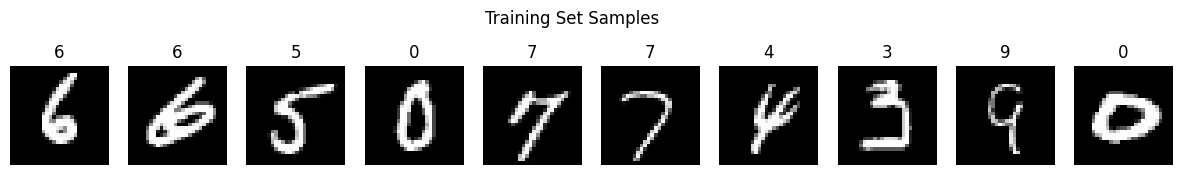

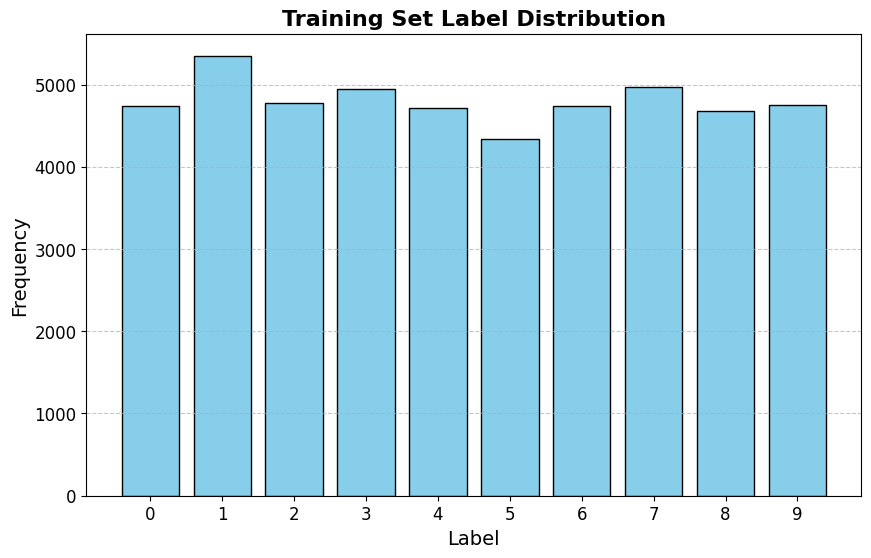

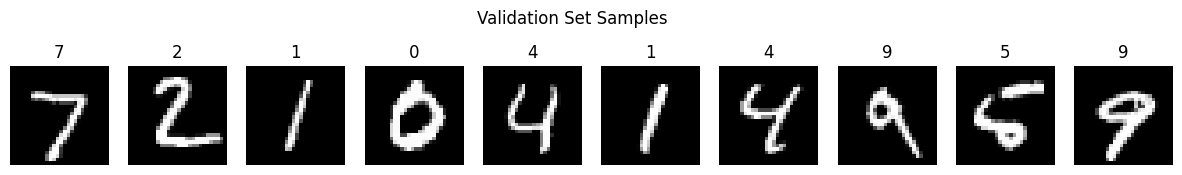

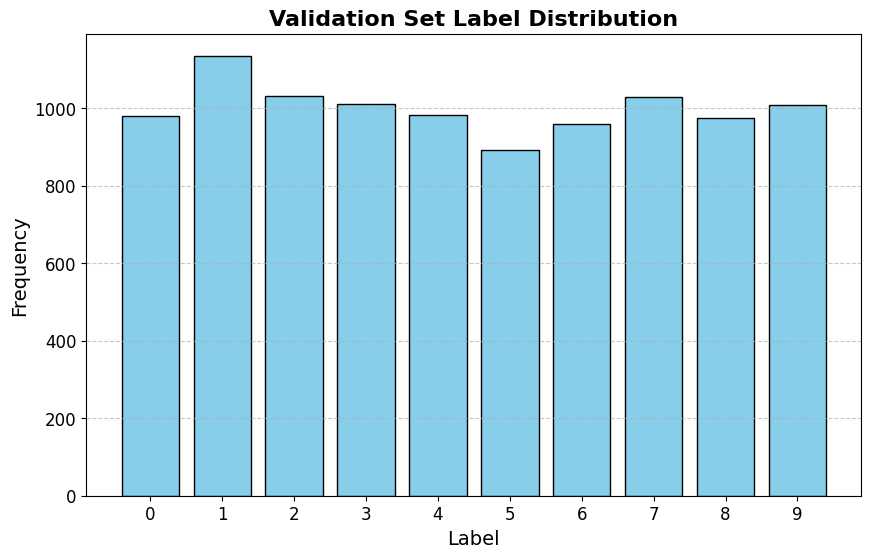

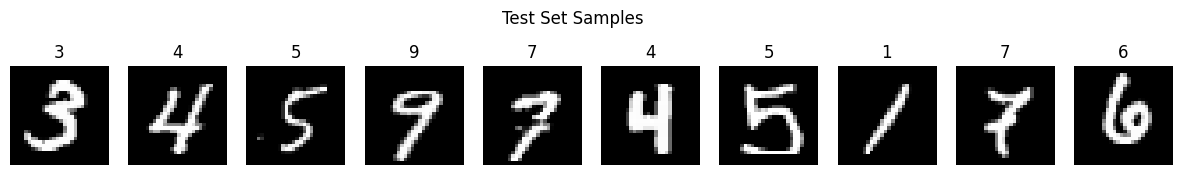

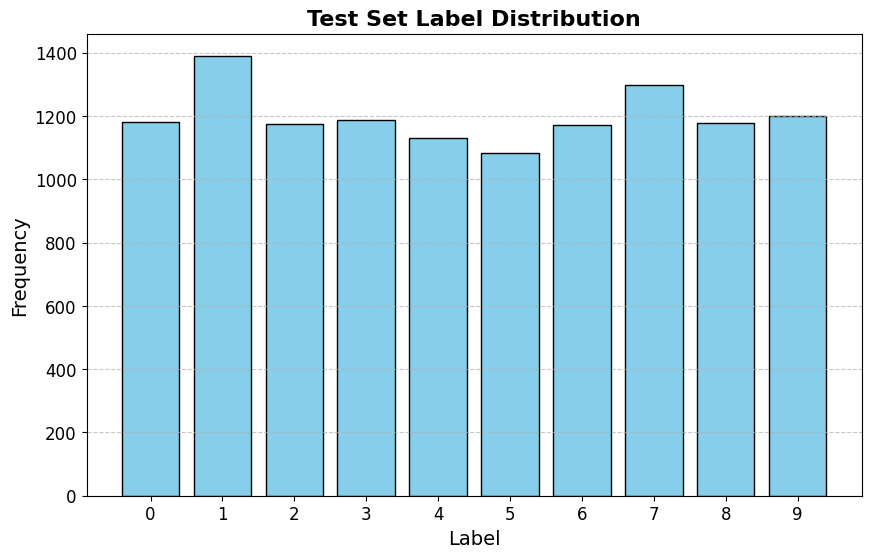

In [3]:
train_loader, val_loader, test_loader = prepare_data()
explore_data(train_loader, "Training Set")
explore_data(test_loader, "Validation Set")
explore_data(val_loader, "Test Set")


Prepare the data for use with the CART algorithm by flattening the images.

In [4]:
def prepare_data_for_cart(data_loader):
    X = []
    y = []
    for images, labels in data_loader:
        # Flatten the images
        images = images.view(images.size(0), -1)
        X.append(images.numpy())
        y.append(labels.numpy())
      
    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
    return X,y

In [5]:
X_train, y_train = prepare_data_for_cart(train_loader)
X_val, y_val = prepare_data_for_cart(val_loader)
X_test, y_test = prepare_data_for_cart(test_loader)

## Part 2: CART Algorithm Implementation

1. Implement the CART algorithm from scratch, including:
   a. Node class to represent tree nodes
   b. DecisionTree class with the following methods:
      - `fit(X, y)`: Train the decision tree
      - `predict(X)`: Make predictions on new data
      - `_build_tree(X, y, depth)`: Recursively build the tree
      - `_find_best_split(X, y)`: Find the best feature and threshold for splitting
      - `_calculate_gini_impurity(y)`: Calculate Gini impurity for a set of labels
2. Your implementation should support the following hyperparameters:
   - `max_depth`: Maximum depth of the tree
   - `min_samples_split`: Minimum number of samples required to split an internal node

Note: Feel free to change, add, and remove functions.

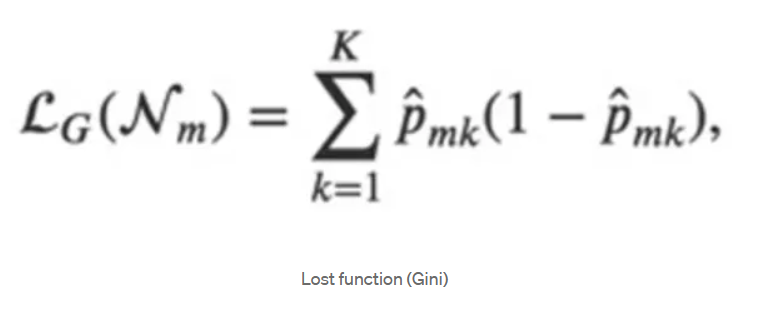

In [6]:
import numpy as np

class TreeNode:
    def __init__(self, split_feature=None, split_threshold=None, left_branch=None, right_branch=None, result=None):
        self.split_feature = split_feature
        self.split_threshold = split_threshold
        self.left_branch = left_branch
        self.right_branch = right_branch
        self.result = result


class DecisionTree_CART:
    def __init__(self, max_depth=10, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def fit(self, X, y):
        """Constructs the decision tree based on training data."""
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, current_depth=0):
        """Grows the decision tree recursively."""
        num_samples, num_features = X.shape
        unique_classes = np.unique(y)

        if (current_depth >= self.max_depth or len(unique_classes) == 1 or num_samples < self.min_samples_split):
            terminal_node_value = self._majority_vote(y)
            return TreeNode(result=terminal_node_value)

        split_feature, split_threshold = self._find_optimal_split(X, y)
        if split_feature is None:
            terminal_node_value = self._majority_vote(y)
            return TreeNode(result=terminal_node_value)

        left_indices, right_indices = self._split_data(X[:, split_feature], split_threshold)
        left_subtree = self._grow_tree(X[left_indices, :], y[left_indices], current_depth + 1)
        right_subtree = self._grow_tree(X[right_indices, :], y[right_indices], current_depth + 1)
        return TreeNode(split_feature=split_feature, split_threshold=split_threshold, left_branch=left_subtree, right_branch=right_subtree)

    def _find_optimal_split(self, X, y):
        """Identifies the feature and threshold that results in the best split."""
        num_samples, num_features = X.shape
        best_gini = float('inf')
        best_feature = None
        best_threshold = None

        for feature_idx in range(num_features):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left_indices, right_indices = self._split_data(X[:, feature_idx], threshold)
                if len(left_indices) == 0 or len(right_indices) == 0:
                    continue

                current_gini = self._compute_gini(left_indices, right_indices, y)
                if current_gini < best_gini:
                    best_gini = current_gini
                    best_feature = feature_idx
                    best_threshold = threshold

        return best_feature, best_threshold

    def _split_data(self, feature_column, threshold):
        """Divides data based on the threshold for a particular feature."""
        left_indices = np.where(feature_column <= threshold)[0]
        right_indices = np.where(feature_column > threshold)[0]
        return left_indices, right_indices

    def _compute_gini(self, left_indices, right_indices, y):
        """Calculates Gini impurity for a given split."""
        n_total = len(left_indices) + len(right_indices)
        gini = 0

        for group in [left_indices, right_indices]:
            if len(group) == 0:
                continue
            proportion = len(group) / n_total
            gini += proportion * self._gini_for_group(y[group])

        return gini

    def _gini_for_group(self, y_group):
        """Computes the Gini index for a specific group."""
        class_counts = np.bincount(y_group)
        probabilities = class_counts / len(y_group)
        return 1.0 - np.sum(probabilities ** 2)

    def _majority_vote(self, y):
        """Determines the most common class in a group."""
        return np.bincount(y).argmax()

    def predict(self, X):
        """Generates predictions for each sample in the test data."""
        return np.array([self._make_prediction(inputs) for inputs in X])

    def _make_prediction(self, inputs):
        """Traverses the tree to predict the class for a single sample."""
        node = self.root
        while node.result is None:
            if inputs[node.split_feature] <= node.split_threshold:
                node = node.left_branch
            else:
                node = node.right_branch
        return node.result


## Part 3: Model Evaluation and Comparison

1. Train your CART implementation on the MNIST training data.
2. Evaluate your model's performance on the test set and report the accuracy.
3. Train scikit-learn's DecisionTreeClassifier on the same data.
4. Compare the performance of your implementation with scikit-learn's version.
5. Create a plot showing how accuracy changes with tree depth for both implementations.

/tmp/ipykernel_23/2674164318.py:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


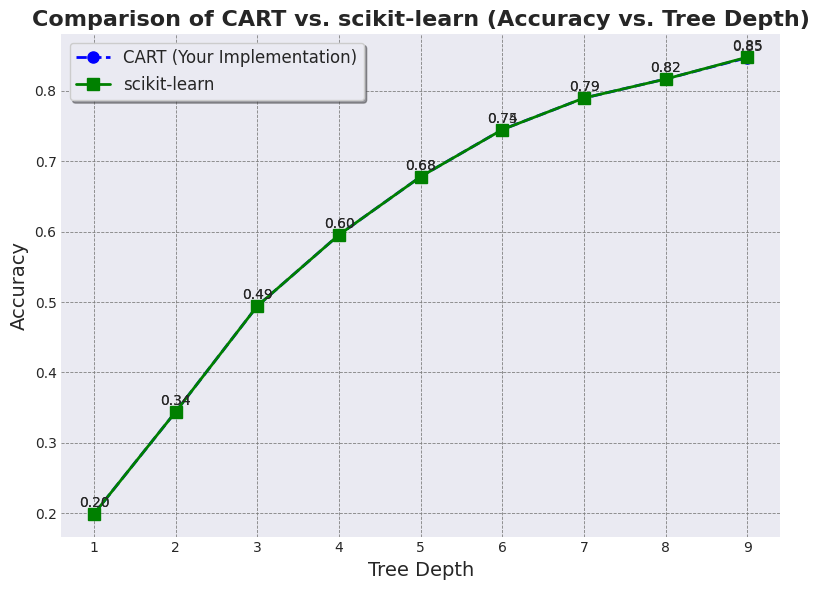

In [9]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier


depths = range(1, 10)
cart_accuracies = []
sklearn_accuracies = []

for depth in depths:
    # Train and evaluate CART implementation
    cart_tree = DecisionTree_CART(max_depth=depth)
    cart_tree.fit(X_train, y_train)
    cart_predictions = cart_tree.predict(X_test)
    cart_acc = accuracy_score(y_test, cart_predictions)
    cart_accuracies.append(cart_acc)

    # Train and evaluate scikit-learn's DecisionTreeClassifier
    sklearn_tree = DecisionTreeClassifier(max_depth=depth)
    sklearn_tree.fit(X_train, y_train)
    sklearn_predictions = sklearn_tree.predict(X_test)
    sklearn_acc = accuracy_score(y_test, sklearn_predictions)
    sklearn_accuracies.append(sklearn_acc)

# Define plot size and style
plt.figure(figsize=(8, 6))
plt.style.use('seaborn-darkgrid')

# Plot the results with improved visuals
plt.plot(depths, cart_accuracies, label='CART (Your Implementation)', marker='o', color='blue', linestyle='--', linewidth=2, markersize=8)
plt.plot(depths, sklearn_accuracies, label='scikit-learn', marker='s', color='green', linestyle='-', linewidth=2, markersize=8)

# Add title and labels with larger font size
plt.title('Comparison of CART vs. scikit-learn (Accuracy vs. Tree Depth)', fontsize=16, fontweight='bold')
plt.xlabel('Tree Depth', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

# Customize legend and grid
plt.legend(loc='best', fontsize=12, frameon=True, shadow=True)
plt.grid(True, which='both', linestyle='--', linewidth=0.6, color='gray')

# Add annotations to highlight key points
for i, txt in enumerate(cart_accuracies):
    plt.annotate(f'{txt:.2f}', (depths[i], cart_accuracies[i]), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=10)
for i, txt in enumerate(sklearn_accuracies):
    plt.annotate(f'{txt:.2f}', (depths[i], sklearn_accuracies[i]), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

## Question
What is the difference between ID3 and CART algorithm

### Difference Between ID3 and CART Algorithms

#### ID3 (Iterative Dichotomiser 3)
1. **Type of Trees**:
   - ID3 is primarily used for creating **classification trees**.

2. **Splitting Criterion**:
   - ID3 uses **Information Gain** based on **Entropy** to decide the best attribute for splitting the data at each node.

3. **Handling of Continuous Variables**:
   - ID3 does not handle continuous variables directly. Continuous variables need to be discretized before using ID3.

4. **Pruning**:
   - ID3 does not have a built-in pruning mechanism. Pruning needs to be done separately to avoid overfitting.

5. **Algorithm Complexity**:
   - ID3 can be computationally expensive due to the calculation of entropy and information gain for each attribute at every node.

#### CART (Classification and Regression Trees)
1. **Type of Trees**:
   - CART can create both **classification trees** and **regression trees**.

2. **Splitting Criterion**:
   - For classification trees, CART uses **Gini Impurity** or **Entropy**.
   - For regression trees, CART uses **Mean Squared Error (MSE)** or other variance reduction criteria.

3. **Handling of Continuous Variables**:
   - CART can handle continuous variables directly by finding the optimal split point.

4. **Pruning**:
   - CART includes a built-in pruning mechanism called **cost complexity pruning** or **minimal cost-complexity pruning** to avoid overfitting.

5. **Algorithm Complexity**:
   - CART is generally more efficient than ID3, especially for large datasets, due to its ability to handle continuous variables and built-in pruning.

### Summary
- **ID3** is mainly used for classification and relies on information gain and entropy, requiring discretization of continuous variables and lacking built-in pruning.
- **CART** is versatile for both classification and regression, handles continuous variables directly, and includes built-in pruning mechanisms, making it more efficient and robust for various types of data.